## **Part 1**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, Dataset, random_split


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

car_class = 1  # Index of the 'car' class in CIFAR-10
plane_class = 8  # Index of the 'plane' class in CIFAR-10
classes_of_interest = [car_class, plane_class]
class_mapping = {car_class: 0, plane_class: 1}
trainset.targets = [class_mapping[label] for label in trainset.targets if label in class_mapping]
indices_of_interest = [i for i in range(len(trainset.targets)) if trainset.targets[i] in classes_of_interest]
subset_trainset = Subset(trainset, indices_of_interest)

trainloader = DataLoader(subset_trainset, batch_size=500, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testset.targets = [class_mapping[label] for label in testset.targets if label in class_mapping]
indices_of_interest_test = [i for i in range(len(testset.targets)) if testset.targets[i] in classes_of_interest]
subset_testset = Subset(testset, indices_of_interest_test)

testloader = DataLoader(subset_testset, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 78484883.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class AlexNetModified(nn.Module):
    def __init__(self):
        super(AlexNetModified, self).__init__()
        self.alexnet = torchvision.models.alexnet(pretrained=True)

        self.alexnet.classifier[6] = nn.Linear(4096, 2)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.alexnet(x)


model = AlexNetModified().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 3

train_loss_list, train_accuracy_list = [], []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(trainloader)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs} - Training Loss: {train_loss:.4f}, Accuracy: {100 * train_accuracy:.2f}%')

In [ ]:
# Evaluation on the test set after training
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

test_accuracy = correct_test / total_test
test_loss /= len(testloader)

print(f'Testing Loss: {test_loss:.4f}, Accuracy: {100 * test_accuracy:.2f}%')


Testing Loss: 0.0000, Accuracy: 100.00%


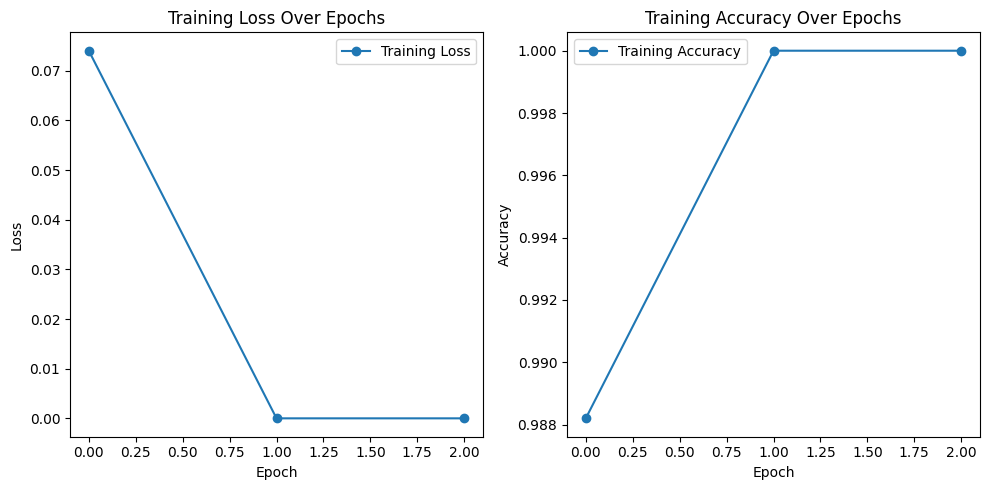

Finished Training


In [ ]:
# Plotting the results
plt.figure(figsize=(10, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting testing accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Training Accuracy', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print('Finished Training')

## **Part 2**

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class TripletCIFAR10(CIFAR10):
    def __init__(self, root, classes_of_interest, transform=None, download=False):
        super(TripletCIFAR10, self).__init__(root, train=True, transform=transform, download=download)
        self.classes_of_interest = classes_of_interest

        self.class_to_images = {i: [] for i in range(len(self.classes))}
        for i, label in enumerate(self.targets):
            if label in self.classes_of_interest:
                self.class_to_images[label].append(i)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        anchor, positive, negative = self.generate_triplet(index)
        anchor_img, anchor_label = super(TripletCIFAR10, self).__getitem__(anchor)
        positive_img, positive_label = super(TripletCIFAR10, self).__getitem__(positive)
        negative_img, negative_label = super(TripletCIFAR10, self).__getitem__(negative)

        return anchor_img, positive_img, negative_img, anchor_label

    def generate_triplet(self, anchor_index):
        anchor_label = self.targets[anchor_index]

        while len(self.class_to_images[anchor_label]) < 2:
            anchor_index = random.randint(0, len(self) - 1)
            anchor_label = self.targets[anchor_index]

        positive_index = random.choice(self.class_to_images[anchor_label])

        negative_label = random.choice(list(set(self.classes_of_interest) - {anchor_label}))
        while len(self.class_to_images[negative_label]) == 0:
            negative_label = random.choice(list(set(self.classes_of_interest) - {anchor_label}))

        negative_index = random.choice(self.class_to_images[negative_label])

        return anchor_index, positive_index, negative_index

In [11]:

classes_of_interest = [3, 8]

triplet_trainset = TripletCIFAR10(root='./data', classes_of_interest=classes_of_interest, transform=transform, download=True)

subset_size = len(triplet_trainset ) // 100

random_subset_indices = random.sample(range(len(triplet_trainset)), subset_size)
subset_train_dataset = Subset(triplet_trainset, random_subset_indices)

triplet_trainloader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True, num_workers=2)

class SiameseAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(SiameseAlexNet, self).__init__()

        self.shared_alexnet_fe = torchvision.models.alexnet(pretrained=True).features

        self.shared_alexnet_cl = torchvision.models.alexnet(pretrained=True).classifier
        self.shared_alexnet_cl[6] = nn.Linear(4096, 2)


    def forward(self, anchor):

        anchor_fe = self.shared_alexnet_fe(anchor)
        anchor_fe1 = anchor_fe.view(anchor_fe.size(0), 256 * 6 * 6)
        anchor_out = self.shared_alexnet_cl(anchor_fe1)

        return anchor_fe,anchor_out

Files already downloaded and verified


In [32]:
model = SiameseAlexNet(2).to(device)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_loss_list21 = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for i, (anchor, positive, negative, anchor_label) in enumerate(triplet_trainloader, 0):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        for param in model.shared_alexnet_cl.parameters():
            param.requires_grad = False

        anchor_fe, anchor_output = model(anchor)
        positive_fe, positive_output = model(positive)
        negative_fe, negative_output = model(negative)
        loss = triplet_loss(anchor_fe, positive_fe, negative_fe)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(triplet_trainloader)
    train_loss_list21.append(average_loss)
    print(f'Epoch {epoch + 1}/{num_epochs} - Training Loss: {average_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Training Loss: 0.8679
Epoch 2/5 - Training Loss: 0.6118
Epoch 3/5 - Training Loss: 0.4895
Epoch 4/5 - Training Loss: 0.4323
Epoch 5/5 - Training Loss: 0.3503


In [33]:
train_loss_list22, train_accuracy_list22 = [], []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        for param in model.shared_alexnet_fe.parameters():
            param.requires_grad = False

        for param in model.shared_alexnet_cl.parameters():
            param.requires_grad = True

        optimizer.zero_grad()
        inputs = nn.functional.interpolate(inputs, size=(224, 224), mode='bilinear', align_corners=False)
        a,outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(trainloader)

    train_loss_list22.append(train_loss)
    train_accuracy_list22.append(train_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs} - Training Loss: {train_loss:.4f}, Accuracy: {100 * train_accuracy:.2f}%')


Epoch 1/5 - Training Loss: 0.0511, Accuracy: 98.84%
Epoch 2/5 - Training Loss: 0.0000, Accuracy: 100.00%
Epoch 3/5 - Training Loss: 0.0000, Accuracy: 100.00%
Epoch 4/5 - Training Loss: 0.0000, Accuracy: 100.00%
Epoch 5/5 - Training Loss: 0.0000, Accuracy: 100.00%


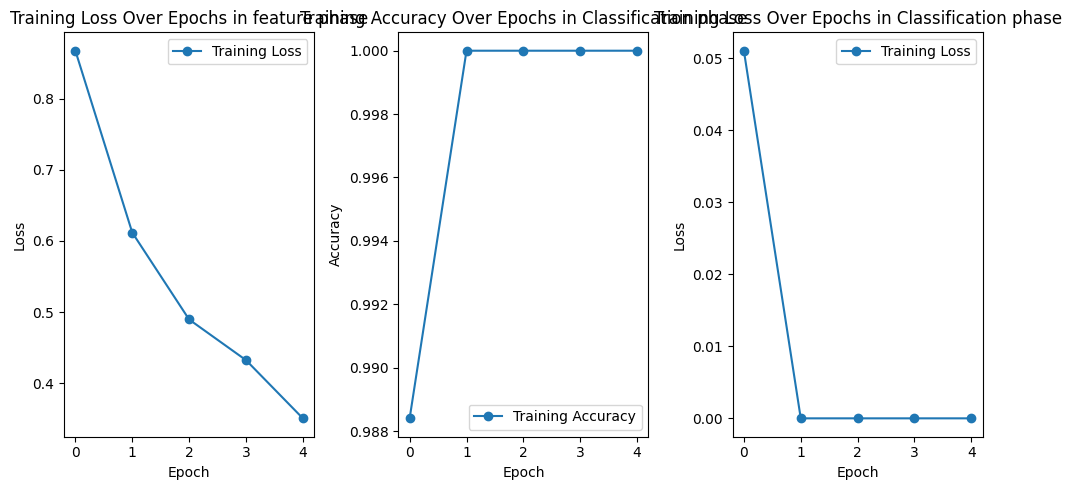

Finished Training


In [35]:
# Plotting the results
plt.figure(figsize=(10, 5))

# Plotting training loss
plt.subplot(1, 3, 1)
plt.plot(train_loss_list21, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs in feature phase')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting testing accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracy_list22, label='Training Accuracy', marker='o')
plt.title('Training Accuracy Over Epochs in Classification phase')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training loss
plt.subplot(1, 3, 3)
plt.plot(train_loss_list22, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs in Classification phase')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Finished Training')

In [38]:
# Evaluation on the test set after training
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        inputs = nn.functional.interpolate(inputs, size=(224, 224), mode='bilinear', align_corners=False)
        a,outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

test_accuracy = correct_test / total_test
test_loss /= len(testloader)

print(f'Testing Loss: {test_loss:.4f}, Accuracy: {100 * test_accuracy:.2f}%')


Testing Loss: 0.0000, Accuracy: 100.00%


## **Part3)**

In [44]:
model = SiameseAlexNet(2).to(device)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
train_loss_list3 = []
train_accuracy_list3 = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for i, (anchor, positive, negative, anchor_label) in enumerate(triplet_trainloader, 0):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        # To train only the new classifier:
        for param in model.parameters():
            param.requires_grad = True
        # محاسبه خروجی‌های مدل و مقدار تابع هزینه
        anchor_fe, anchor_output = model(anchor)
        positive_fe, positive_output = model(positive)
        negative_fe, negative_output = model(negative)
        loss_triplet = triplet_loss(anchor_fe, positive_fe, negative_fe)
        try:
            loss_class = criterion(anchor_output, anchor_label)
        except:
            loss_class = 0
        loss = loss_triplet + loss_class

        # بهینه‌سازی
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = anchor_output.max(1)
        total_train += anchor_label.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracy_list3.append(train_accuracy)

    average_loss = total_loss / len(triplet_trainloader)
    train_loss_list3.append(average_loss)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


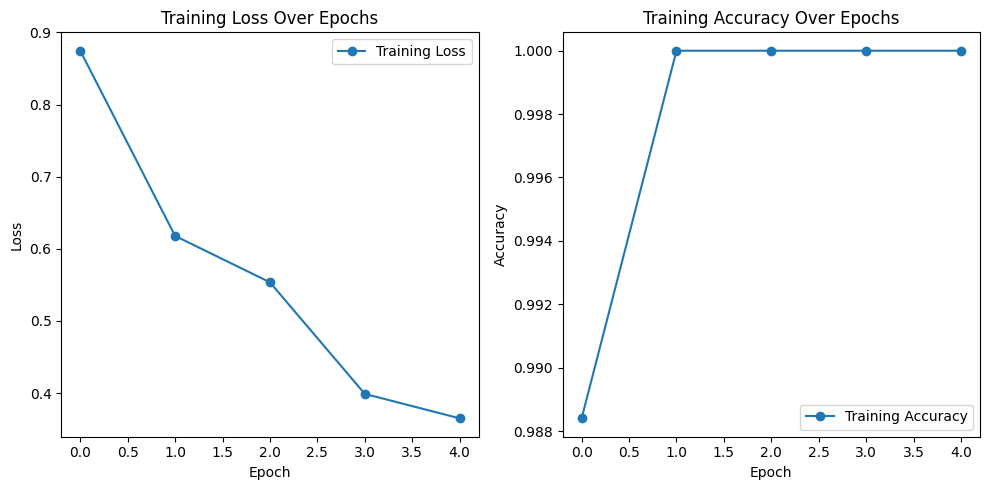

Finished Training


In [48]:
# Plotting the results
plt.figure(figsize=(10, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list3, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting testing accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list3, label='Training Accuracy', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print('Finished Training')

In [49]:
# Evaluation on the test set after training
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        inputs = nn.functional.interpolate(inputs, size=(224, 224), mode='bilinear', align_corners=False)
        a,outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

test_accuracy = correct_test / total_test
test_loss /= len(testloader)

print(f'Testing Loss: {test_loss:.4f}, Accuracy: {100 * test_accuracy:.2f}%')

Testing Loss: 0.0000, Accuracy: 100%
